[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239469-lesson-2-breakpoints)

# Breakpoints

## Review

For `human-in-the-loop`, we often want to see our graph outputs as its running. 

We laid the foundations for this with streaming. 

## Goals

Now, let's talk about the motivations for `human-in-the-loop`:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

LangGraph offers several ways to get or update agent state to support various `human-in-the-loop` workflows.

First, we'll introduce [breakpoints](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage), which provide a simple way to stop the graph at specific steps. 

We'll show how this enables user `approval`.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_google_genai langgraph_sdk langgraph-prebuilt python-dotenv


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

if GOOGLE_API_KEY:
    # print(GOOGLE_API_KEY)
    print("yea")
else:
    print("no")

yea


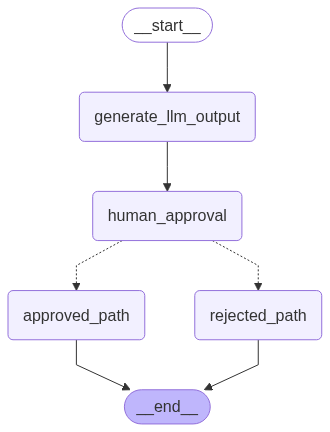

In [19]:
from typing import Literal, TypedDict
import uuid
from IPython.display import Image, display
from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver

# Define the shared graph state
class State(TypedDict):
    llm_output: str
    decision: str

# Simulate an LLM output node
def generate_llm_output(state: State) -> State:
    return {"llm_output": "This is the generated output."}

# Human approval node
def human_approval(state: State) -> Command[Literal["approved_path", "rejected_path"]]:
    decision = interrupt({
        "question": "Do you approve the following output?",
        "llm_output": state["llm_output"]
    })

    if decision == "approve":
        return Command(goto="approved_path", update={"decision": "approved"})
    else:
        return Command(goto="rejected_path", update={"decision": "rejected"})

# Next steps after approval
def approved_node(state: State) -> State:
    print("✅ Approved path taken.")
    return state

# Alternative path after rejection
def rejected_node(state: State) -> State:
    print("❌ Rejected path taken.")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_llm_output", generate_llm_output)
builder.add_node("human_approval", human_approval)
builder.add_node("approved_path", approved_node)
builder.add_node("rejected_path", rejected_node)

builder.set_entry_point("generate_llm_output")
builder.add_edge("generate_llm_output", "human_approval")
builder.add_edge("approved_path", END)
builder.add_edge("rejected_path", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [20]:

# Run until interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)
print(result["__interrupt__"])
# Output:
# Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': 'This is the generated output.'}, ...)


[Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': 'This is the generated output.'}, id='740140e268357827f18ac7b9ff440b59')]


In [21]:
# Simulate resuming with human input
# To test rejection, replace resume="approve" with resume="reject"
final_result = graph.invoke(Command(resume="reject"), config=config)

print(final_result)

❌ Rejected path taken.
{'llm_output': 'This is the generated output.', 'decision': 'rejected'}


In [22]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt
from langgraph.prebuilt import create_react_agent

# An example of a sensitive tool that requires human review / approval
def book_hotel(hotel_name: str):
    """Book a hotel"""
    response = interrupt(  
        f"Trying to call `book_hotel` with args {{'hotel_name': {hotel_name}}}. "
        "Please approve or suggest edits."
    )
    if response["type"] == "accept":
        pass
    elif response["type"] == "edit":
        hotel_name = response["args"]["hotel_name"]
    else:
        raise ValueError(f"Unknown response type: {response['type']}")
    return f"Successfully booked a stay at {hotel_name}."

checkpointer = InMemorySaver() 

agent = create_react_agent(
    model=ChatGoogleGenerativeAI(model="gemini-2.0-flash"),
    tools=[book_hotel],
    checkpointer=checkpointer, 
)

In [23]:
config = {
   "configurable": {
      "thread_id": "1"
   }
}

for chunk in agent.stream( {"messages": [ {"role": "user", "content": "book a stay at McKittrick hotel"} ] } , config):
    print(chunk)
    print("\n")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'book_hotel', 'arguments': '{"hotel_name": "McKittrick hotel"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--93c79e75-6e0a-421b-97ab-7a729bcfbb9a-0', tool_calls=[{'name': 'book_hotel', 'args': {'hotel_name': 'McKittrick hotel'}, 'id': 'e0db0400-d7e8-4604-ba34-88e83d0d7c12', 'type': 'tool_call'}], usage_metadata={'input_tokens': 22, 'output_tokens': 10, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}})]}}


{'__interrupt__': (Interrupt(value="Trying to call `book_hotel` with args {'hotel_name': McKittrick hotel}. Please approve or suggest edits.", id='552bdf80c8cbf7cf56dcd94fe737428e'),)}




In [25]:
from langgraph.types import Command

for chunk in agent.stream(Command(resume= {"type": "edit"} ), config):
    print(chunk)
    # Command(resume={"type": "edit", "args": {"hotel_name": "McKittrick Hotel"}}),
    print("\n")
    

## Breakpoints for human approval

Let's re-consider the simple agent that we worked with in Module 1. 

Let's assume that we are concerned about tool use: we want to approve the agent to use any of its tools.
 
All we need to do is simply compile the graph with `interrupt_before=["tools"]` where `tools` is our tools node.

This means that the execution will be interrupted before the node `tools`, which executes the tool call.

In [29]:
from langchain_google_genai import ChatGoogleGenerativeAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

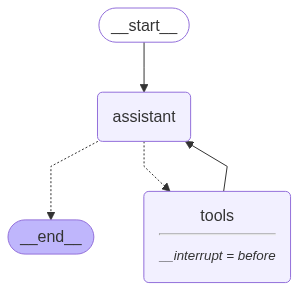

In [31]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return { "messages": [ llm_with_tools.invoke( [sys_msg] + state["messages"] )] }

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
# =================================================================================
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)
# =================================================================================

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [32]:
# Input
initial_input = { "messages": HumanMessage(content="Multiply 2 and 3") }

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (47e86be6-76f4-479c-a3fd-6d2892578b51)
 Call ID: 47e86be6-76f4-479c-a3fd-6d2892578b51
  Args:
    b: 3.0
    a: 2.0


We can get the state and look at the next node to call.

This is a nice way to see that the graph has been interrupted.

In [34]:
state = graph.get_state(thread)
state.next

('tools',)

Now, we'll introduce a nice trick.

When we invoke the graph with `None`, it will just continue from the last state checkpoint!

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

For clarity, LangGraph will re-emit the current state, which contains the `AIMessage` with tool call.

And then it will proceed to execute the following steps in the graph, which start with the tool node.

We see that the tool node is run with this tool call, and it's passed back to the chat model for our final answer.

In [35]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (47e86be6-76f4-479c-a3fd-6d2892578b51)
 Call ID: 47e86be6-76f4-479c-a3fd-6d2892578b51
  Args:
    b: 3.0
    a: 2.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


Now, lets bring these together with a specific user approval step that accepts user input.

In [37]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (0684e449-eb2d-4bad-a016-8f74ec8df22e)
 Call ID: 0684e449-eb2d-4bad-a016-8f74ec8df22e
  Args:
    b: 3.0
    a: 2.0


Do you want to call the tool? (yes/no):  YES


================================== Ai Message ==================================
Tool Calls:
  multiply (0684e449-eb2d-4bad-a016-8f74ec8df22e)
 Call ID: 0684e449-eb2d-4bad-a016-8f74ec8df22e
  Args:
    b: 3.0
    a: 2.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


### Breakpoints with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

The LangGraph API [supports breakpoints](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_breakpoint/#sdk-initialization). 

In [38]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [39]:
# This is the URL of the local development server
from langgraph_sdk import get_client

client = get_client(url="http://127.0.0.1:2024")

As shown above, we can add `interrupt_before=["node"]` when compiling the graph that is running in Studio.

However, with the API, you can also pass `interrupt_before` to the stream method directly. 

In [40]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

thread = await client.threads.create()

async for chunk in client.runs.stream(thread["thread_id"], assistant_id="agent", input=initial_input, stream_mode="values", interrupt_before=["tools"]):
    print(f"Receiving new event of type: {chunk.event}...")
    
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '66c6a15e-7ce4-4d34-a95a-48d046a0a2dc', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, 'response_metadata': {'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, 'type': 'ai', 'name': None, 'id': 'run--44468d30-b603-4969-88ed-ac7c9c48225c-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': '3b80c320-5b28-41a1-a7ff-58db3ba52df8', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 63, 'output_tokens': 5, 't

Now, we can proceed from the breakpoint just like we did before by passing the `thread_id` and `None` as the input!

In [41]:
async for chunk in client.runs.stream(thread["thread_id"], "agent", input=None, stream_mode="values", interrupt_before=["tools"]):
    print(f"Receiving new event of type: {chunk.event}...")
    
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, 'response_metadata': {'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, 'type': 'ai', 'name': None, 'id': 'run--44468d30-b603-4969-88ed-ac7c9c48225c-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': '3b80c320-5b28-41a1-a7ff-58db3ba52df8', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 63, 'output_tokens': 5, 'total_tokens': 68, 'input_token_details': {'cache_read': 0}}}
--------------------------------------------------
Receiving new event of type: values...
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '789c34